In [9]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [10]:
IMAGE_SIZE = 96
NUM_KEYPOINTS = 10
HEATMAP_SIZE = 24


In [11]:
def soft_argmax(heatmaps):
    b, c, h, w = heatmaps.shape
    heatmaps = heatmaps.view(b, c, -1)
    heatmaps = torch.nn.functional.softmax(heatmaps, dim=-1)
    coords = torch.arange(h * w, device=heatmaps.device).float()
    y = (coords // w).view(1, 1, -1)
    x = (coords % w).view(1, 1, -1)
    x = (heatmaps * x).sum(dim=2)
    y = (heatmaps * y).sum(dim=2)
    return torch.stack([x, y], dim=2)

In [12]:
# ViT-style backbone (simplified)
class SimpleViT(nn.Module):
    def __init__(self, num_keypoints):
        super().__init__()
        self.backbone = torchvision.models.resnet18(pretrained=False)
        self.backbone.fc = nn.Identity()  # Remove classifier
        self.head = nn.Sequential(
            nn.Linear(512, HEATMAP_SIZE * HEATMAP_SIZE * num_keypoints),
        )
        self.num_keypoints = num_keypoints

    def forward(self, x):
        b = x.size(0)
        feat = self.backbone(x)
        out = self.head(feat)
        out = out.view(b, self.num_keypoints, HEATMAP_SIZE, HEATMAP_SIZE)
        return out

In [16]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

stl10 = torchvision.datasets.STL10(root='/media/miju_chowdhury/Miju/Datasets/data', split='unlabeled', download=True, transform=transform)
loader = DataLoader(stl10, batch_size=16, shuffle=True)


  0%|          | 1.54M/2.64G [00:08<3:54:43, 187kB/s]


KeyboardInterrupt: 

In [ ]:
model = SimpleViT(NUM_KEYPOINTS).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Dummy training with image reconstruction as target (placeholder)
for epoch in range(5):
    for imgs, _ in loader:
        imgs = imgs.cuda()

        heatmaps = model(imgs)
        coords = soft_argmax(heatmaps)

        # Fake target: center of image (for demo)
        target = torch.tensor([[IMAGE_SIZE // 2, IMAGE_SIZE // 2]] * NUM_KEYPOINTS, dtype=torch.float32).unsqueeze(0).repeat(imgs.size(0), 1, 1).cuda()
        
        loss = criterion(coords, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


In [ ]:
def show_keypoints(img, keypoints):
    img = img.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    for x, y in keypoints:
        plt.plot(x * (IMAGE_SIZE / HEATMAP_SIZE), y * (IMAGE_SIZE / HEATMAP_SIZE), 'ro')
    plt.show()

# Example:
model.eval()
with torch.no_grad():
    sample_img, _ = stl10[0]
    sample_input = sample_img.unsqueeze(0).cuda()
    heatmaps = model(sample_input)
    coords = soft_argmax(heatmaps)
    show_keypoints(sample_img, coords[0].cpu())


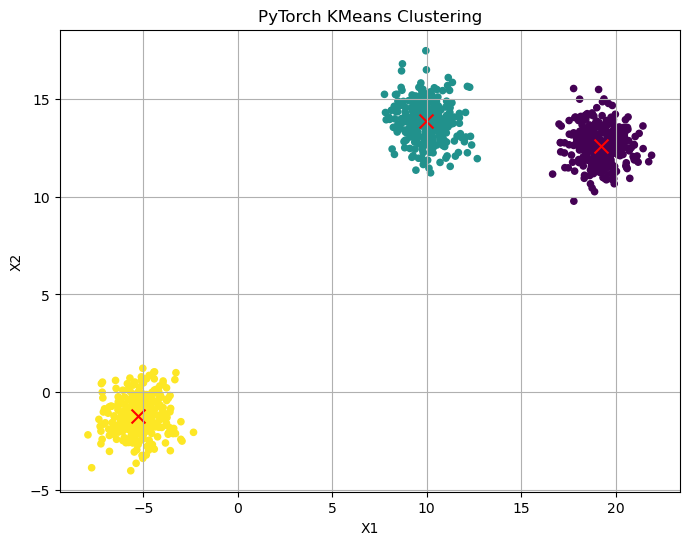

In [15]:
import torch
import matplotlib.pyplot as plt

# Generate synthetic 2D data (for visualization simplicity)
def generate_data(num_samples=300):
    center_1 = torch.randn(2) * 5
    center_2 = torch.randn(2) * 5 + 10
    center_3 = torch.randn(2) * 5 + 20

    cluster_1 = center_1 + torch.randn(num_samples, 2)
    cluster_2 = center_2 + torch.randn(num_samples, 2)
    cluster_3 = center_3 + torch.randn(num_samples, 2)

    return torch.cat([cluster_1, cluster_2, cluster_3], dim=0)

# KMeans function
def kmeans(X, k=3, num_iters=10):
    # Randomly choose k points as initial centroids
    indices = torch.randperm(X.size(0))[:k]
    centroids = X[indices]

    for _ in range(num_iters):
        # Compute distances to each centroid
        distances = torch.cdist(X, centroids)

        # Assign each point to the closest centroid
        labels = distances.argmin(dim=1)

        # Recalculate centroids
        new_centroids = []
        for i in range(k):
            if (labels == i).sum() == 0:
                new_centroids.append(centroids[i])
            else:
                new_centroids.append(X[labels == i].mean(dim=0))
        centroids = torch.stack(new_centroids)

    return labels, centroids

# Main script
X = generate_data()
labels, centroids = kmeans(X, k=3)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=20)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100)
plt.title("PyTorch KMeans Clustering")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.show()


In [18]:
class RotateSTL10(datasets.STL10):
    all_perms = [0,45,90,135,180,225,270]

    def __getitem__(self, index):
        img = self.data[index]
        img = Image.fromarray(np.transpose(img,(1,2,0)))
        rand_int = random.randint(0,len(self.all_perms)-1)
        img = FT.rotate(img, angle=self.all_perms[rand_int])
        if self.transform is not None:
            img = self.transform(img)
        return img, rand_int

NameError: name 'datasets' is not defined

In [19]:
train_data = RotateSTL10(data_set_root, split = 'train+unlabled', download = True, transform = transform)
test_data = RotateSTL10(data_set_root, split = 'test', download=True, transform = transform)

validation_split = 0.9
n_train_examples = int(len(train_data)*validation_split)
n_valid_examples = len(train_data)-n_train_examples
train_data, valid_data = torch.utils.data.random_split(train_data, 
                                                       [n_train_examples, n_valid_examples],
                                                       generator=torch.Generator().manual_seed(42))

NameError: name 'RotateSTL10' is not defined